In [1]:
import numpy as np
import os
import fabio
import matplotlib.pyplot as plt
import pandas as pd
import pyFAI
import glob
import re

from pyFAI.multi_geometry import MultiGeometry
from pyFAI.gui import jupyter
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator as AzInt
import scipy.io

## function below is CURRENTLY HARD CODED FOR PILATUS IMAGES

In [2]:
def load_image(imageFullname):
    """
    author: Fang Ren (SSRL), Robert Tang-Kong
    version: 1.1

    returns: numpy array with image data
    CURRENTLY HARD CODED FOR PILATUS
    """
    # get extension to consider
    ext = os.path.splitext(imageFullname)[1]
    #print(imageFullname)
    imArray = np.array([])
    if ext.lower() in ['.tif', '.tiff']:
        # open tiff image
        im = fabio.open(imageFullname)
        # input image object into a numpy array
        imArray = im.data
    elif ext.lower() in ['.raw']:
        # extract raw file
        im = open(imageFullname, 'rb')
        arr = np.fromstring(im.read(), dtype='int32')
        im.close()

        #raw requires prompting for dimensions, hard code for now
        arr.shape = (195, 487)
        imArray = np.array(arr)

    return imArray

## Initialize paths. 
*  Assumes images are in a subdirectory of the spec-path
*  Assumes export directory exists (try creating one programatically?)
*  Uses spec file to translate detector
*  Only tested for pliatus 100k in horizontal orientation

In [7]:
# Organize paths and collect images to integrate

exportPath = os.path.join(os.getcwd(), '181029 2-1 Time', 'export_1')
specPath = "P:\\bl2-1\\Feb2020\\20200203_Cu_SE1_dry_XRD\\"
#os.path.join(os.getcwd(), '181029 2-1 Time', 'data_1')
specFiles = glob.glob(os.path.join(specPath, '*.csv')) # use re to be more precise
specs = [pd.read_csv(x, index_col=0).rename(columns=lambda x: x.strip()) for x in specFiles]
user = 'b_mehta_'
imgPath = "P:\\bl2-1\\Feb2020\\20200203_Cu_SE1_dry_XRD\\images\\"

#os.path.join(specPath, 'images')

# define detector.  
det = pyFAI.detectors.Pilatus100k()

# define detector geometry
# USER MUST CHANGE THIS VALUE
centerPx1, centerPx2 = (94, 248)

In [4]:
# List of all detectors loaded.  
pyFAI.detectors.ALL_DETECTORS

# probe detector information to confirm.  Pilatus pixel size should be 172um x 172um
det.pixel1 # in mm

0.000172

P:\bl2-1\Feb2020\20200203_Cu_SE1_dry_XRD\images\b_mehta_20200203_Cu_SE1_dry_Gi0p10_scan1_0024.raw
<ipython-input-2-fb70fc8dd7a4>:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  arr = np.fromstring(im.read(), dtype='int32')


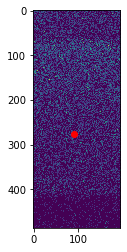

In [5]:
testPath = os.path.join(imgPath, 'b_mehta_20200203_Cu_SE1_dry_Gi0p10_scan1_0024.raw')
print(testPath)
img = load_image(testPath)

# if detector is portrait mode, need to rotate images
plt.imshow(np.rot90(img, k=1))#[:, 100:400])
plt.scatter(91, 277, c='r')

# # if detector is landscape, can use as is
# plt.imshow(img)
# plt.scatter(277, 91, c='r')

In [36]:
np.shape(img)

(195, 487)

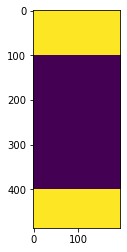

In [31]:
# # if landscape
# mask = np.ones(np.shape(img))
# mask[:, 100:400] = 0
# if portrait
mask = np.ones(np.shape(np.rot90(img, k=3)))
mask[100:400, :] = 0 # zero's are valid
plt.imshow(mask)

In [40]:
mask[90, 100]

1.0

In [9]:
specPath

'P:\\bl2-1\\Feb2020\\20200203_Cu_SE1_dry_XRD\\'

In [8]:
imgGlob = glob.glob(imgPath + '*Cu_SE1_dry_Gi0p10_scan1*.raw')
spec = pd.read_csv(specPath)
spec.rename(columns=lambda x: x.strip(), inplace=True)

print(specPath)
print(len(list(imgGlob)))
imgs = []
ais = []

#imgGlob = list(imgGlob)[:4]

for rawPath in imgGlob:
    # Append img to list of images
    img = load_image(rawPath)
    
    imgs.append(np.rot90(img, k=1))

    # Append calibrated ai to list of ai's
    scanNo = int(re.search('(\d{4})(\.raw)', rawPath).group(1))
    ai = AzInt(dist=0.714728, poni1=centerPx2*det.pixel1, poni2=centerPx1*det.pixel1, detector=det, 
               wavelength=7.29319E-11, 
               rot2=np.pi/180*float(spec['TwoTheta'][scanNo]), # tth rotation
               rot3=-np.pi/2) # For bringing azimuth to 0
    ais.append(ai)

mg = MultiGeometry(ais, unit="2th_deg", radial_range=(0, 70), azimuth_range=(-90, 90))
fig, ax = plt.subplots(2, 1, figsize=(8,12))

int1d = mg.integrate1d(imgs, 10000, lst_mask=mask)
ax[0].plot(int1d[0], int1d[1])
ax[0].set_ylabel('Intensity')
ax[0].set_xlim(0,65)

res2d = mg.integrate2d(imgs, 1000,360, lst_mask=mask)
# gives 3 arrays.  First is intensities with shape (arg2, arg1)  Second is 2th range, third is azimuthal range

ax[1].pcolormesh(res2d[1], res2d[2], np.log(res2d[0]), cmap = 'viridis')

ax[1].set_xlim(0,65)
ax[1].set_xlabel('Radial Angle 2theta')
ax[1].set_ylabel('Azumuthal Angle chi')

OSError: Initializing from file failed